In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from dipy.io.image import save_nifti
import numpy as np
from dipy.data import read_stanford_hardi, read_stanford_pve_maps
import torch
import torch.nn as nn
from dipy.segment.mask import median_otsu

from scipy.ndimage.morphology import binary_erosion

import difreewater

### Load data

In [2]:
# Diffusion weighted data
img, gtab = read_stanford_hardi()
dwi = img.get_data()

# Segmentation maps
(csf, gm, wm) = [map.get_data()==1.0 for map in read_stanford_pve_maps()]

# The provided segmentation maps are quite noisy in the lower parts of the brain, so we clip the segmentation maps 
# at z=25, and use only the ventricles for CSF data.
v_mask = np.zeros(csf.shape)
(x,y,z) = np.divide(csf.shape,2).astype(np.int)
v_mask[x-15:x+15,y-20:y+20,z-5:z+5] = 1
csf = np.logical_and(csf, v_mask)

wm[:,:,:25] = 0
gm[:,:,:25] = 0

# Erode the maps so obtained exemplary voxels are not contaminated by other tissue
csf, gm, wm = [binary_erosion(map) for map in (csf, gm, wm)]

maskdata, mask = median_otsu(dwi, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=True, dilate=2)

Dataset is already in place. If you want to fetch it again please first remove the folder /Users/leon/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /Users/leon/.dipy/stanford_hardi 


### Create the synthetic training data set

In [9]:
synDataLoader = difreewater.SynDiffData(gtab, dwi, csf_mask=csf, gm_mask=gm, wm_mask=wm)
syn_diff_data, water_fraction = synDataLoader.create_waterfraction_data(sample_size=2500) # this may take a while

### Neural network training

In [10]:
net = difreewater.learning.DifreewaterNet(synDataLoader.datashape, 1)

optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
num_epochs = 100
criterion = nn.MSELoss()

mse, me = difreewater.learning.train(syn_diff_data, water_fraction, net, criterion, num_epochs, optimizer)

Epoch 0: MSE=0.014732442650228035, ME=0.0894858620603815
Epoch 10: MSE=0.0015963460702526477, ME=0.03225342698714217
Epoch 20: MSE=0.0010291500857171649, ME=0.024594103613029567
Epoch 30: MSE=0.001018703681462355, ME=0.024478367185653938
Epoch 40: MSE=0.0010359418234593895, ME=0.02470907924766562
Epoch 50: MSE=0.001053637901972898, ME=0.02496456768979497
Epoch 60: MSE=0.0010614694621613216, ME=0.025044347965494356
Epoch 70: MSE=0.0010689435138765769, ME=0.025144255291207975
Epoch 80: MSE=0.0010774657857815766, ME=0.025273297947922792
Epoch 90: MSE=0.0010882329003159847, ME=0.02539457429233251


### Predict and correct the water fraction in the original data

In [11]:
f_fw_predicted, dwi_water_corrected = difreewater.dehydrate(maskdata, mask, synDataLoader, net)

/Users/leon/PycharmProjects/fwe_public/difreewater/syn_data.py:188: RuntimeWarning: divide by zero encountered in true_divide
  edw = voxels / np.expand_dims(S0, axis=1)
/Users/leon/PycharmProjects/fwe_public/difreewater/syn_data.py:188: RuntimeWarning: invalid value encountered in true_divide
  edw = voxels / np.expand_dims(S0, axis=1)
/Users/leon/PycharmProjects/fwe_public/difreewater/water_correction.py:15: RuntimeWarning: divide by zero encountered in true_divide
  S_orig = np.divide(S_orig, b0)
/Users/leon/PycharmProjects/fwe_public/difreewater/water_correction.py:15: RuntimeWarning: invalid value encountered in true_divide
  S_orig = np.divide(S_orig, b0)
/Users/leon/PycharmProjects/fwe_public/difreewater/water_correction.py:28: RuntimeWarning: divide by zero encountered in true_divide
  S_corr = np.divide(S_orig - S_watercompartment, np.expand_dims(1-f, axis=1))
/Users/leon/PycharmProjects/fwe_public/difreewater/water_correction.py:30: RuntimeWarning: invalid value encountered i

### Visualizations and save data

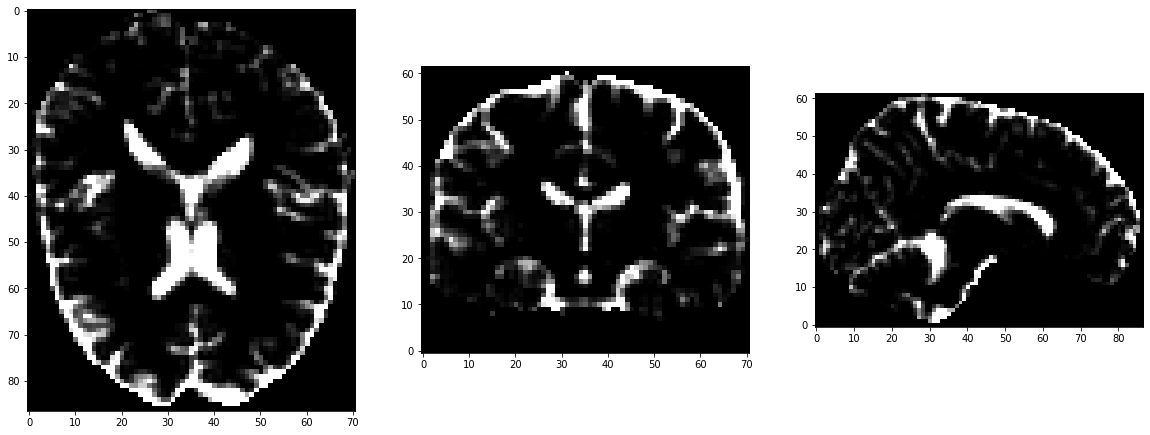

In [12]:
plt.rcParams["figure.figsize"] = (20,10)
plt.figure('water fraction')
plt.subplot(1, 3, 1)
plt.imshow(f_fw_predicted[:,:,30].T, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(f_fw_predicted[:,40,:].T, origin='lower', cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(f_fw_predicted[30,:,:].T, origin='lower', cmap='gray')

save_nifti("f_fw.nii.gz", f_fw_predicted, img.affine)
save_nifti("dwi_fwe.nii.gz", dwi_water_corrected, img.affine)